In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd "/content/drive/MyDrive/cs7643-deep-learning/project"

In [3]:
# !nvidia-smi -L

In [4]:
# !pip install -q -U watermark

In [5]:
# !pip install -qq transformers

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import gc
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 77
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# data = pd.read_csv("yelp_humor_merged_v1.csv")
# data = pd.read_csv("./data/yelp_merged_data.csv")
# data

In [5]:
# word_cnt_threshold=400
# humor_threshold=10

In [6]:
# df = data[(data['word_count'] <= word_cnt_threshold) & ((data['funny']>=humor_threshold) | (data['funny'] == 0))]
# df

In [7]:
# df['humor'].value_counts()

In [8]:
# df['funny'].value_counts()

In [9]:
# humor_sample = min(10000, df['humor'].value_counts()[1])
# humor_sample

In [10]:
# not_humor_split = 0.5
# not_humor_sample = int(humor_sample * (not_humor_split) / (1 - not_humor_split))
# not_humor_sample

In [11]:
# df_humor = df[df['humor']==1]
# df_humor = df_humor.sample(n=humor_sample, random_state=RANDOM_SEED)
# df_humor

In [12]:
# df_not_humor = df[df['humor']==0]
# df_not_humor = df_not_humor.sample(n=not_humor_sample, random_state=RANDOM_SEED)
# df_not_humor

In [13]:
# df = pd.concat([df_humor, df_not_humor])
df = pd.read_csv("./data/yelp_reduced.csv")
df

,business_id,name,city,state,categories,funny,text,word_count,humor
0,lmszYzjgz5T3-57doPbqCw,Finale,Brookline,MA,"Bakeries, Desserts, Restaurants, Food",22,The classic place to go for your 3rd date! Doe...,194,1
1,vVdD8heYO10aErcB-QZ3Lg,Broadway Grill & Brewery,Portland,OR,"Sports Bars, Bakeries, Gastropubs, Restaurants...",10,I had one of the worst microbrews I have ever ...,136,1
2,K48RyUD_dYWfknfS9h0Fwg,Tatte Bakery & Cafe,Cambridge,MA,"Cafes, Coffee & Tea, Restaurants, Food, Breakf...",15,I love Tatte Bakery. It's packed here so be pr...,253,1
3,I7atR1yTJMOgSoZLXLtCWA,Golden Dynasty,Orlando,FL,"Pakistani, Chinese, Event Planning & Services,...",16,My wife and I had an appointment in the area s...,282,1
4,Gs4lOF2OuftG6iQl-iOVdQ,Trillium Brewing - Fort Point,Boston,MA,"Beer, Wine & Spirits, Food, Local Flavor, Rest...",10,"I don't know what being ""Elite"" on Yelp means,...",272,1
...,...,...,...,...,...,...,...,...,...
19995,wkQ1nCkrNlo25fRd3LCQUw,Tampopo,Cambridge,MA,"Restaurants, Japanese",0,The pork cutlet curry and Katsu don is amazing...,17,0
19996,AOiNvHQUa5tAJN7Xt4176A,Tiki Rock,Boston,MA,"Cocktail Bars, Bars, Tiki Bars, Nightlife, Sus...",0,Food was decent but waitress for outdoor patio...,52,0
19997,zO_OZS-ZaBp54segpbU6uA,Fado Irish Pub,Columbus,OH,"Irish Pub, Nightlife, Bars, Pubs, Restaurants,...",0,"Only been there once, but it was a cool place ...",44,0
19998,m9asd2P7kgub8eYYVbyLXg,Seito Sushi Sand Lake,Orlando,FL,"Japanese, Bars, Asian Fusion, Restaurants, Nig...",0,"Excellent food & drinks, friendly staff, clean...",28,0


In [14]:
class_names = ['not funny', 'funny']

In [15]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
# PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [16]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [17]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, truncation=True)
  token_lens.append(len(tokens))

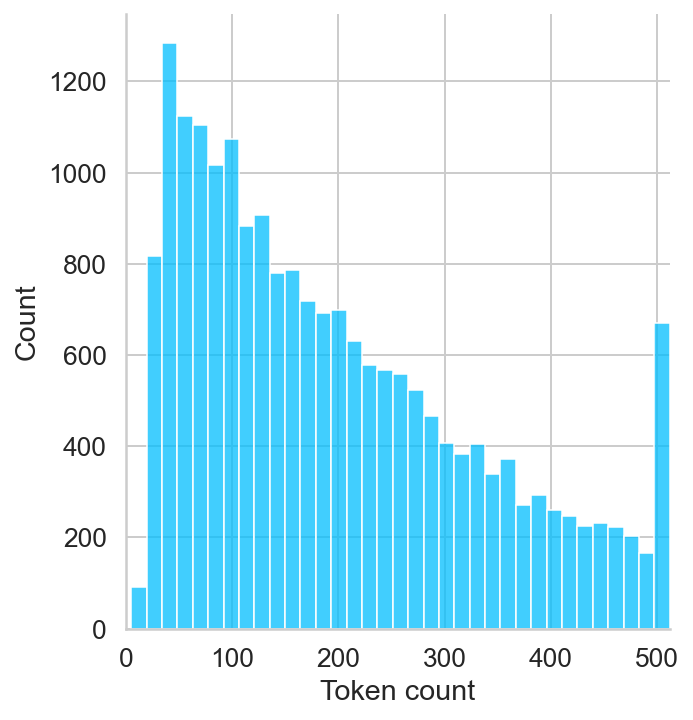

In [18]:
sns.displot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [19]:
(np.array(token_lens) == 512).sum()

515

In [20]:
# del data, df_humor, df_not_humor, tokens
del tokens
gc.collect()

129

In [21]:
MAX_LEN = 512

In [22]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [23]:


df_train, df_test = train_test_split(df, test_size=0.3, stratify=df.humor, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, stratify=df_test.humor, random_state=RANDOM_SEED)

In [24]:
df_train['humor'].value_counts()

0    7000
1    7000
Name: humor, dtype: int64

In [25]:
df_val['humor'].value_counts()

0    1500
1    1500
Name: humor, dtype: int64

In [26]:
df_test['humor'].value_counts()

0    1500
1    1500
Name: humor, dtype: int64

In [27]:
df_train.shape, df_val.shape, df_test.shape

((14000, 9), (3000, 9), (3000, 9))

In [28]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.humor.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [29]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
class HumorClassifier(nn.Module):

  def __init__(self, n_classes):
    super(HumorClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME,  return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = HumorClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

In [ ]:
EPOCHS = 4

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
model = HumorClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True humor')
  plt.xlabel('Predicted humor');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True humor: {class_names[true_sentiment]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('humor')
plt.xlabel('probability')
plt.xlim([0, 1]);